In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostClassifier
import shap
import lime
import lime.lime_tabular

# Загрузка данных

## Датасет с информацией о ранее выданных организацией займах

In [2]:
df1 = pd.read_csv('new_training_data_31_08_2022.csv', index_col=0)

## Датасет с данными о клиентах, оставлявших заявки на займ, но в итоге не взявших его по причине отказа финансовой организации или нежеланию самого клиента

In [3]:
df2 = pd.read_csv('all_reject_data.csv', index_col=0)

Будем проводить анализ 2-х датасетов сразу. И удалять признаки тоже

In [4]:
df = pd.concat([df1, df2])

In [5]:
df = df.reset_index(drop=True)

# Анализ данных и первичный отбор признаков

## Первичный анализ

In [6]:
df.head()

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,9.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,11.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,26.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0


In [7]:
len(df)

149040

In [8]:
all(df.dtypes == float)

True

Все столбцы численные

In [9]:
df.describe() # смотрим статистики по всем столбцам

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,149040.000000,149040.000000,149040.000000,148893.00000,148893.000000,149040.000000,149040.000000,149040.000000,1.490400e+05,149040.000000,...,149040.000000,149040.000000,149040.000000,149040.000000,149040.000000,149040.000000,149040.000000,149040.000000,1.448600e+05,42529.000000
mean,33.363580,29.137118,307.682783,3.09175,1733.474717,13.387245,40.363808,1.986520,1.578954e+05,11.236587,...,8.714567,0.030878,0.085091,8.978174,0.030280,0.052784,6.032092,65.194371,NaN,0.277458
std,8.903511,100.436634,3625.279321,49.63859,7659.052945,12.353431,69.986857,3.840825,2.205046e+05,11.203209,...,9.535458,0.243625,0.424658,12.110558,0.236901,0.273688,7.074289,51.800308,NaN,0.447750
min,18.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf,0.000000
25%,27.000000,3.000000,0.000000,0.00000,1.000000,4.000000,7.000000,0.000000,2.520000e+04,3.000000,...,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,7.000000,0.000000e+00,0.000000
50%,32.000000,6.000000,0.000000,0.00000,3.000000,10.000000,20.000000,0.000000,8.304450e+04,8.000000,...,6.000000,0.000000,0.000000,5.000000,0.000000,0.000000,4.000000,59.000000,1.972755e-01,0.000000
75%,38.000000,17.000000,0.000000,0.00000,10.000000,19.000000,48.000000,2.000000,2.121732e+05,16.000000,...,13.000000,0.000000,0.000000,12.000000,0.000000,0.000000,9.000000,120.000000,1.129444e+00,1.000000
max,76.000000,5655.000000,44785.000000,2779.00000,44775.000000,153.000000,6743.000000,75.000000,2.199029e+07,141.000000,...,123.000000,12.000000,27.000000,394.000000,8.000000,12.000000,90.000000,120.000000,inf,1.000000


In [10]:
descr = df.describe().transpose()

In [11]:
descr

,count,mean,std,min,25%,50%,75%,max
age,149040.0,33.363580,8.903511,18.0,27.0,32.000000,38.000000,76.0
lastcredit,149040.0,29.137118,100.436634,1.0,3.0,6.000000,17.000000,5655.0
time_to_lastcredit_closeddt,149040.0,307.682783,3625.279321,0.0,0.0,0.000000,0.000000,44785.0
close_loan_median,148893.0,3.091750,49.638590,0.0,0.0,0.000000,0.000000,2779.0
open_loan_median,148893.0,1733.474717,7659.052945,0.0,1.0,3.000000,10.000000,44775.0
...,...,...,...,...,...,...,...,...
is_active_type_consumer_1,149040.0,0.052784,0.273688,0.0,0.0,0.000000,0.000000,12.0
is_active_type_micro_1,149040.0,6.032092,7.074289,0.0,1.0,4.000000,9.000000,90.0
overall_worst_overdue_state_12,149040.0,65.194371,51.800308,0.0,7.0,59.000000,120.000000,120.0
ratio_sum_outstanding_to_open_sum,144860.0,NaN,NaN,-inf,0.0,0.197275,1.129444,inf


In [12]:
descr[descr['min'] == descr['max']]

,count,mean,std,min,25%,50%,75%,max
overdue_loans_12,149040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
overdue_loans_3,149040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ratio_overdue_loans_3_to_12,127333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3 столбца имеют только нулевые значения, удалим их

In [13]:
df.drop(columns=['overdue_loans_12', 'overdue_loans_3', 'ratio_overdue_loans_3_to_12'], inplace=True)

## Анализ пропущенных значений и их обработка 

In [14]:
null_values = df.isnull().sum() # смотрим столбцы, где присутствуют пропущенные значения

In [15]:
null_values[null_values > 0]

close_loan_median                          147
open_loan_median                           147
ratio_all_microloans_3_to_12               621
ratio_history_100                           27
ratio_history_12                           514
fraction_last_x_12                          27
ratio_history_3                           2602
fraction_last_x_3                           27
ratio_history_1                           4267
fraction_last_x_1                           27
ratio_mean_delay_3_to_12                  5464
ratio_pattern_len_to_pattern_1             147
ratio_pattern_len_to_pattern_2             147
ratio_pattern_len_to_pattern_3             147
ratio_pattern_len_to_pattern_4             147
ratio_pattern_len_to_pattern_bad_len       147
ratio_sum_outstanding_to_open_sum         4180
target                                  106511
dtype: int64

видно, что есть несколько столбцов количеством пропусков, которое равно 147 или 27, что вряд ли является совпадением. Проанализируем данные столбцы

In [16]:
null_values[null_values == 147]

close_loan_median                       147
open_loan_median                        147
ratio_pattern_len_to_pattern_1          147
ratio_pattern_len_to_pattern_2          147
ratio_pattern_len_to_pattern_3          147
ratio_pattern_len_to_pattern_4          147
ratio_pattern_len_to_pattern_bad_len    147
dtype: int64

In [17]:
cols_147 = null_values[null_values == 147].index

### Из описания к задаче:
- **close_loan_median** - Медиана, взятая по количеству дней между закрытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между закрытием предыдущего и следующего микрокредита
- **open_loan_median** - Медиана, взятая по количеству дней между открытием предыдущего и следующего микрокредита (считается по всем последовательно открытым микрозаймам), т.е. сколько в среднем проходит времени между открытием предыдущего и следующего микрокредита
- **ratio_pattern_len_to_pattern_1** - Отношение количества платежей в платежном паттерне к общему количеству запланированных платежей на данный момент
- **ratio_pattern_len_to_pattern_2** - Отношение количества просрочек в 0-5 дней в платежном паттерне к общему количеству запланированных платежей на данный момент
- **ratio_pattern_len_to_pattern_3** -
- **ratio_pattern_len_to_pattern_4** -
- **ratio_pattern_len_to_pattern_bad_len** - Отношение количества символов сильной просрочки (> 60 дней) в платежном паттерне к общему количеству символов в строке

In [18]:
index_set = set()
for i in cols_147:
    index_set.add(tuple(df[df[i].isnull()].index))

In [19]:
len(index_set)

1

Значит есть 147 строк, в которых одновременно отсутствует 7 данных признаков.
Их проще удалить, чем обрабатывать

In [20]:
df.drop(df[df['close_loan_median'].isnull()].index, inplace=True)
df = df.reset_index(drop=True)

In [21]:
df

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,39.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,9.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,11.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,26.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148888,31.0,4.0,0.0,0.0,2.0,7.0,5.0,2.0,44425.0,7.0,...,6.0,0.0,0.0,9.0,0.0,0.0,6.0,29.0,0.623940,NaN
148889,34.0,61.0,0.0,0.0,23.0,4.0,13.0,6.0,5000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,2.606580,NaN
148890,42.0,1.0,0.0,0.0,2.0,16.0,8.0,0.0,136070.0,16.0,...,14.0,0.0,0.0,16.0,0.0,0.0,14.0,0.0,0.000000,NaN
148891,28.0,3.0,0.0,0.0,4.0,6.0,5.0,0.0,30200.0,6.0,...,5.0,0.0,0.0,7.0,0.0,0.0,5.0,0.0,0.000000,NaN


Тоже самое проделаем для значения 27

In [22]:
cols_27 = null_values[null_values == 27].index

### Из описания к задаче:
- **ratio_history_100** - Доля не возвращенных кредитов относительно всех кредитов, взятых за все время
- **fraction_last_x_12** - Доля кредитов, взятых за последние 12 месяцев, относительно всех кредитов истории
- ...

In [23]:
index_set = set()
for i in cols_27:
    index_set.add(tuple(df[df[i].isnull()].index))

In [24]:
len(index_set)

1

Значит есть 27 строк, в которых одновременно отсутствует 4 данных признака.
Их проще удалить, чем обрабатывать

In [25]:
df.drop(df[df['ratio_history_100'].isnull()].index, inplace=True)
df = df.reset_index(drop=True)

Прежде чем удалять признаки с ненулевым количеством пропусков (либо удалять строки, содержащие их), посмотрим их корреляцию с таргетом, вдруг они очень сильно коррелируют, тогда их, вероятно, лучше обработать, чем удалить

In [26]:
null_values = df.isnull().sum()

In [27]:
null_values[null_values > 0]

ratio_all_microloans_3_to_12            471
ratio_history_12                        410
ratio_history_3                        2474
ratio_history_1                        4128
ratio_mean_delay_3_to_12               5337
ratio_sum_outstanding_to_open_sum      4112
target                               106370
dtype: int64

In [28]:
cols_null = null_values[null_values > 0].index

### Описание оставшихся признаков с пропусками:
- **ratio_all_microloans_3_to_12** - Отношение количества микрокредитов, взятых за последние 3 месяца, к количеству микрокредитов, взятых за последние 12 месяцев
- **ratio_history_12** - Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 12 месяцев
- **ratio_history_3** - Доля не возвращенных кредитов относительно всех кредитов, взятых за последние 3 месяца
- **ratio_history_1** - Доля не возвращенных кредитов относительно всех кредитов, взятых за последний месяц
- **ratio_mean_delay_3_to_12** - Отношение средней просрочки за последние 3 месяца к средней просрочке за последние 12 месяцев (в днях, с лагом по времени в 2 месяца)
- **ratio_sum_outstanding_to_open_sum** - Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю

Прежде чем заниматься удалением данных признаков проанализируем насколько все признаки информативны для предсказания таргета.
Рассматривать придётся только строки из df1

### Анализ inf и -inf значений

In [29]:
inf_counts = df.isin([np.inf, -np.inf]).sum()

In [30]:
inf_counts[inf_counts > 0]

ratio_sum_outstanding_to_open_sum    1993
dtype: int64

пронализируем данный признак

In [31]:
inf_feature = df['ratio_sum_outstanding_to_open_sum']

In [32]:
inf_feature.value_counts()

0.000000     40590
inf           1976
1.000000       175
2.500000        97
0.574407        36
             ...  
11.427600        1
0.702949         1
0.216021         1
0.182663         1
5.102111         1
Name: ratio_sum_outstanding_to_open_sum, Length: 100928, dtype: int64

In [33]:
inf_feature = inf_feature[(inf_feature < np.inf) & (inf_feature > -np.inf)]

In [34]:
max_f = max(inf_feature)
min_f = min(inf_feature)

-inf и inf заменим на 0

In [35]:
df.loc[df['ratio_sum_outstanding_to_open_sum'] == np.inf, 'ratio_sum_outstanding_to_open_sum'] = 0
df.loc[df['ratio_sum_outstanding_to_open_sum'] == -np.inf, 'ratio_sum_outstanding_to_open_sum'] = 0

In [36]:
df['ratio_sum_outstanding_to_open_sum'].value_counts()

0.000000     42583
1.000000       175
2.500000        97
0.574407        36
1.250000        12
             ...  
11.427600        1
0.702949         1
0.216021         1
0.182663         1
5.102111         1
Name: ratio_sum_outstanding_to_open_sum, Length: 100926, dtype: int64

## Анализ информативности признаков для таргета

In [37]:
df_target = df[~df['target'].isnull()]

In [38]:
X = df_target.drop(columns='target')

In [39]:
target_1 = df_target[df_target['target'] == 1][X.columns]
target_0 = df_target[df_target['target'] == 0][X.columns]

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


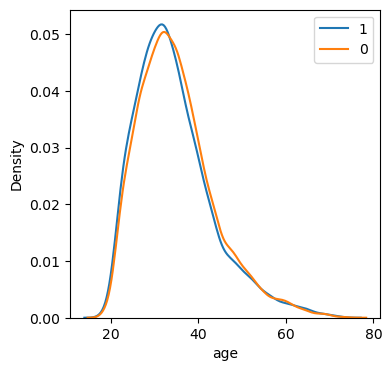

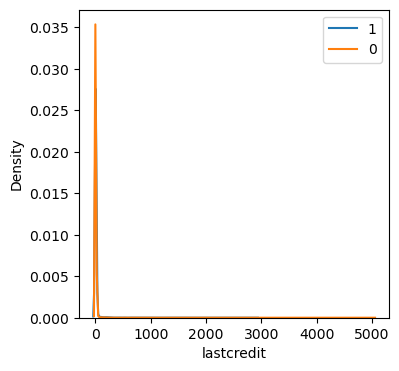

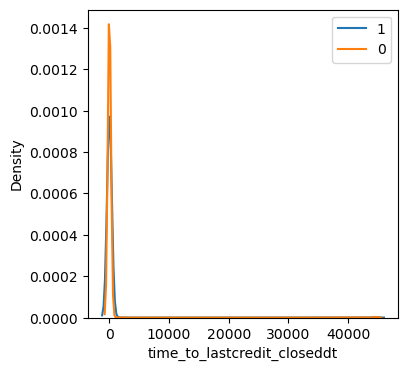

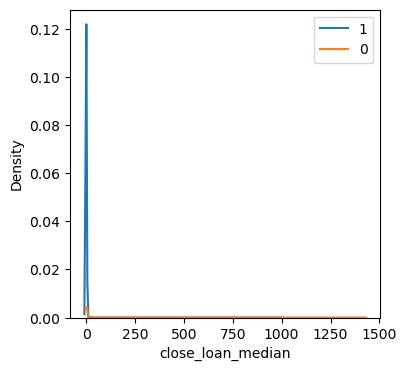

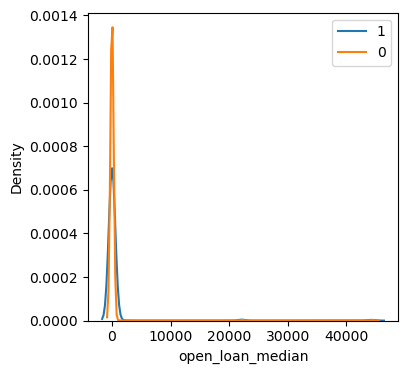

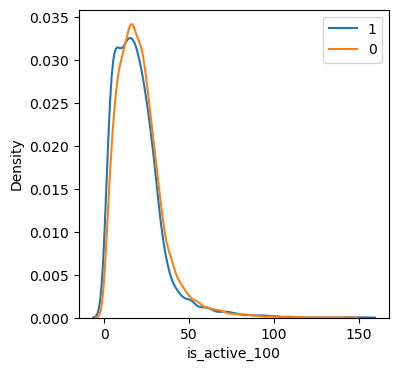

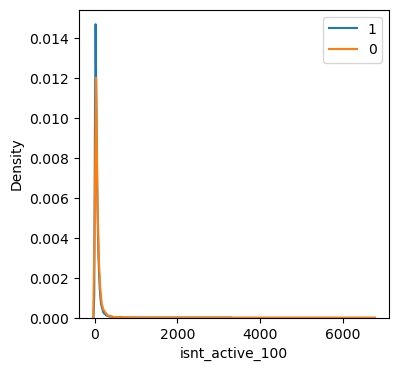

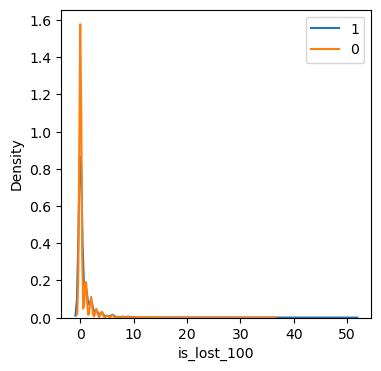

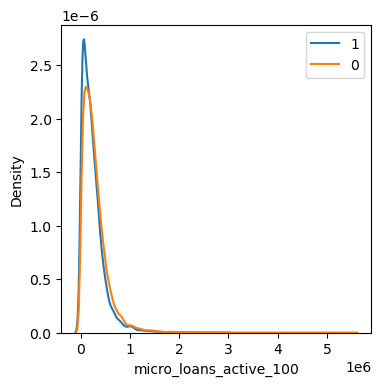

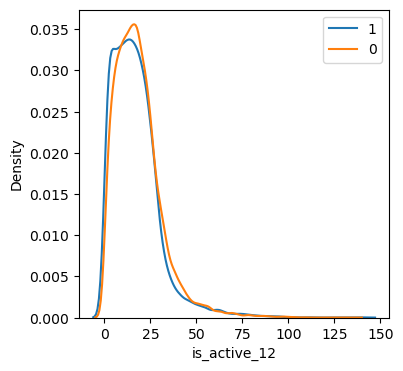

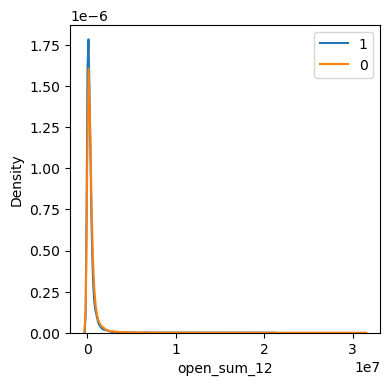

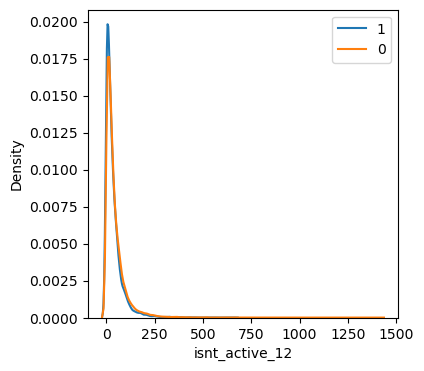

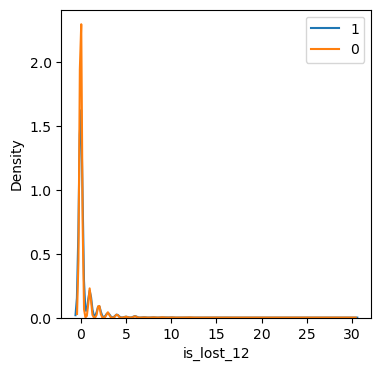

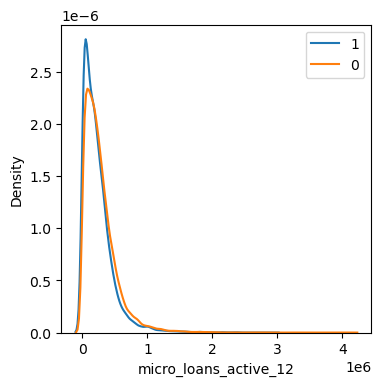

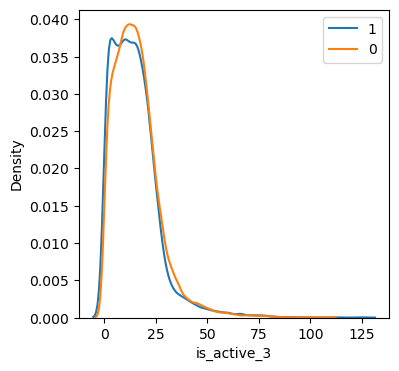

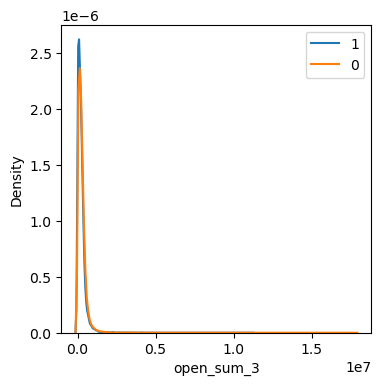

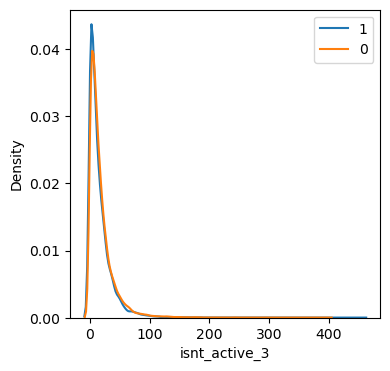

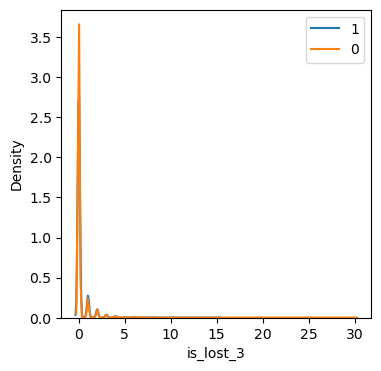

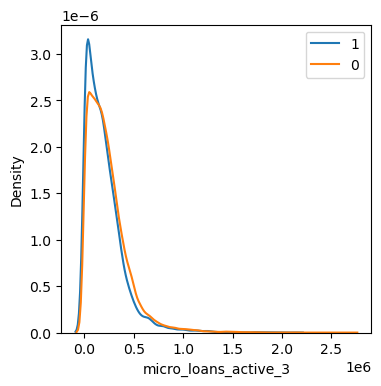

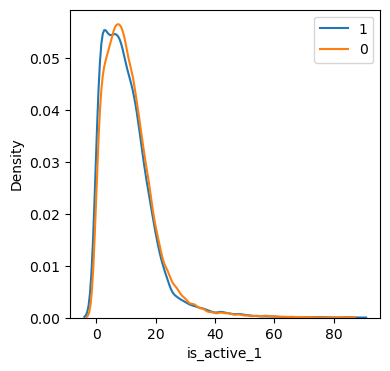

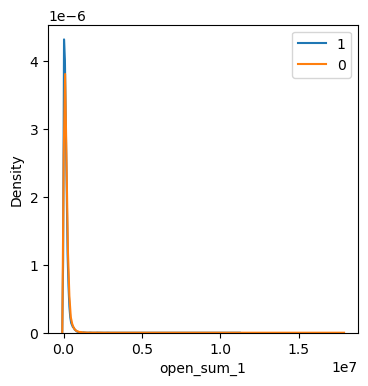

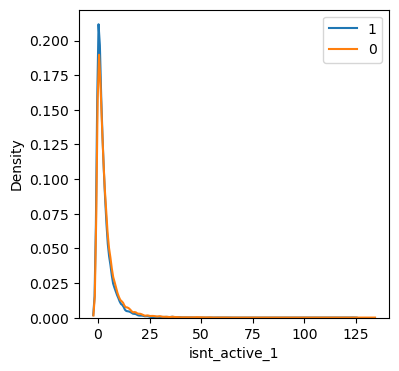

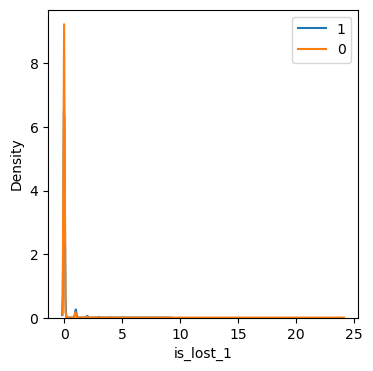

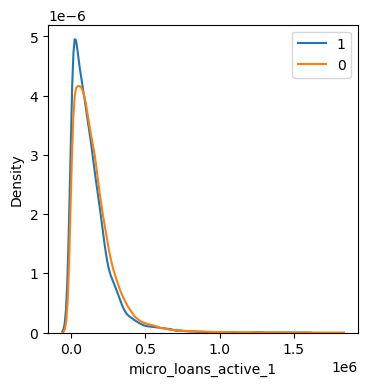

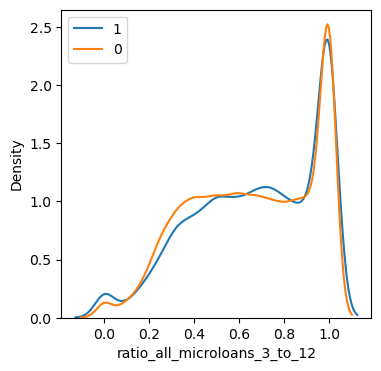

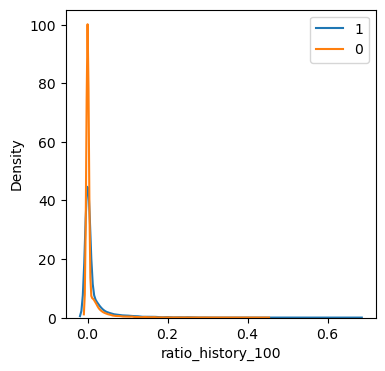

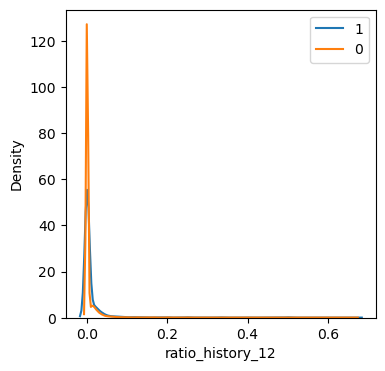

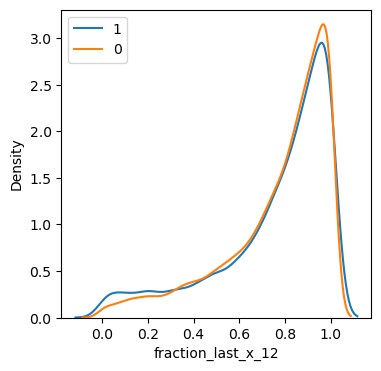

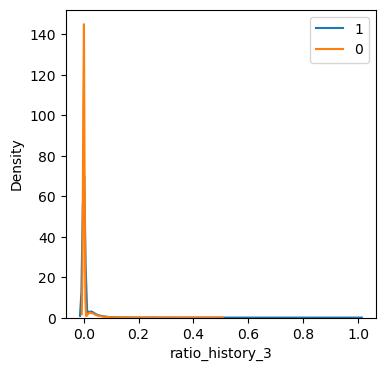

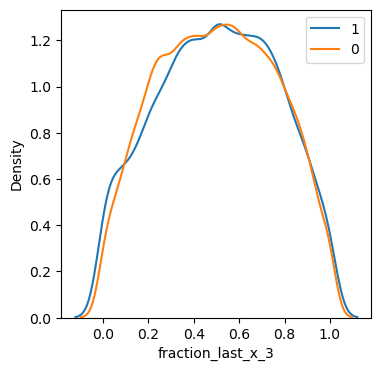

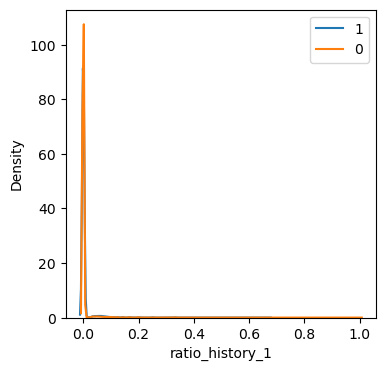

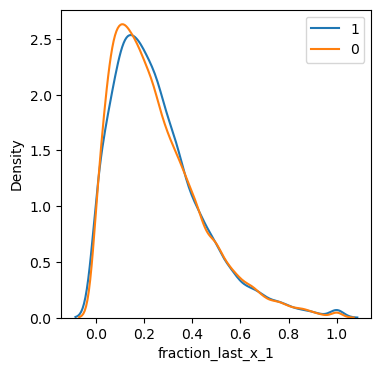

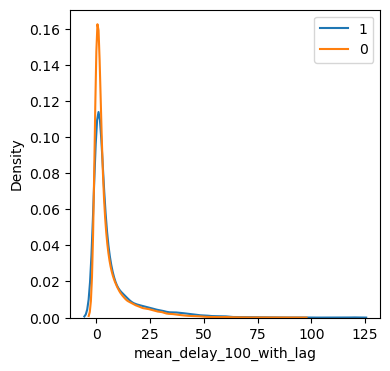

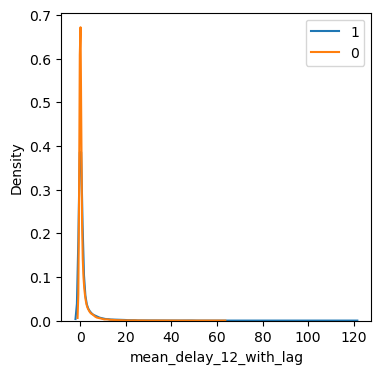

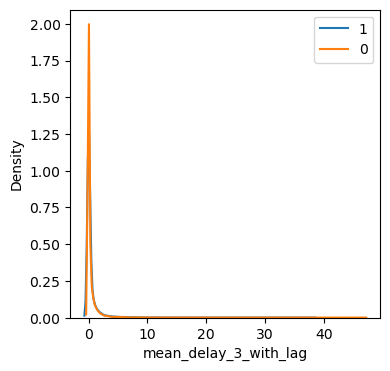

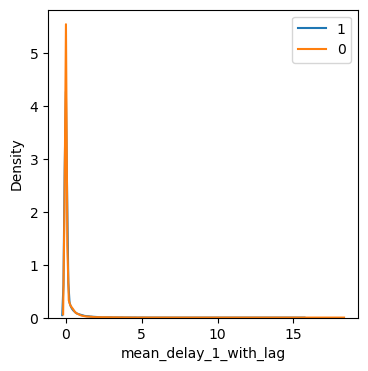

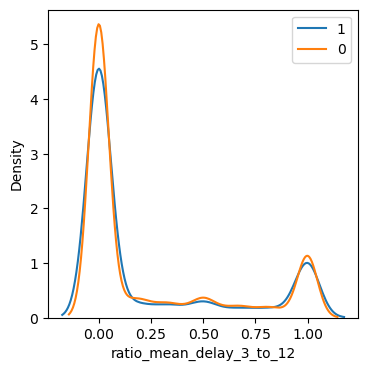

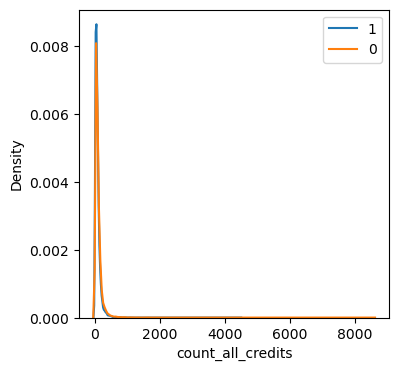

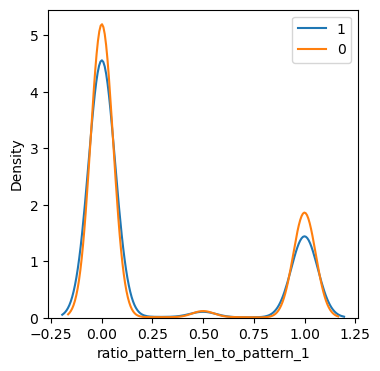

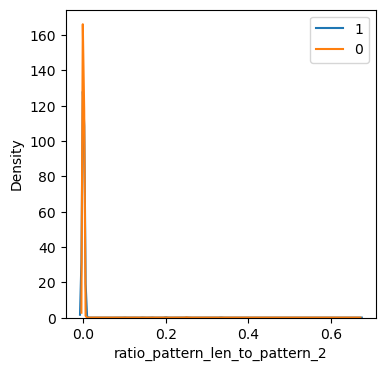

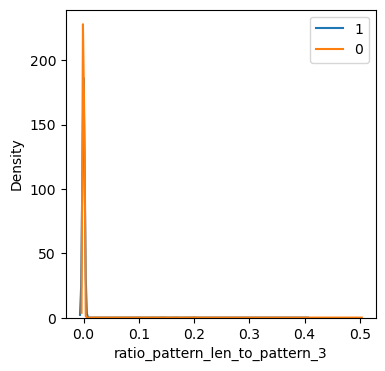

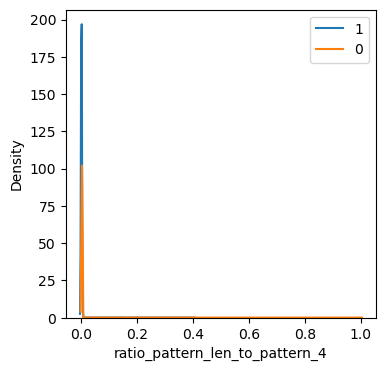

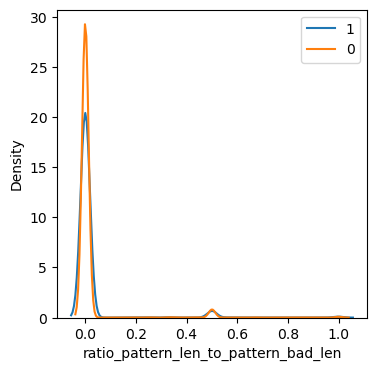

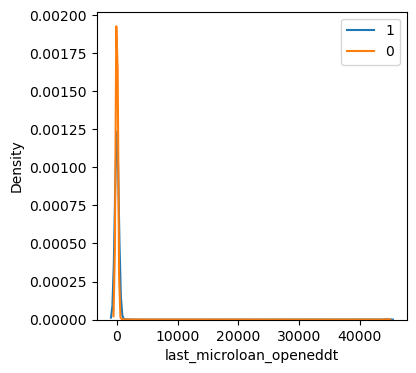

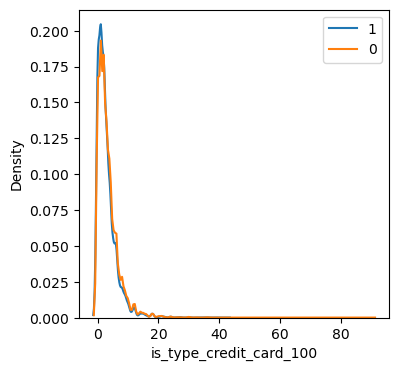

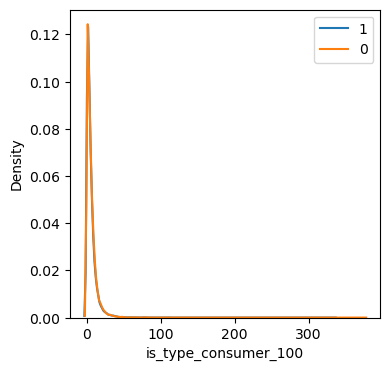

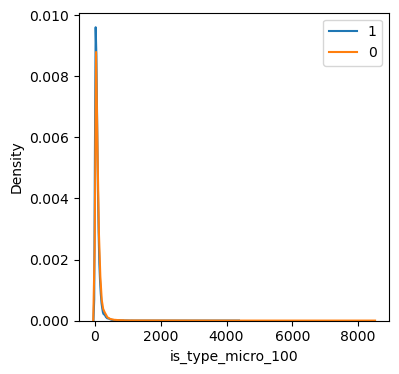

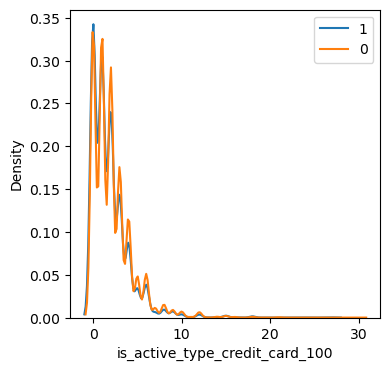

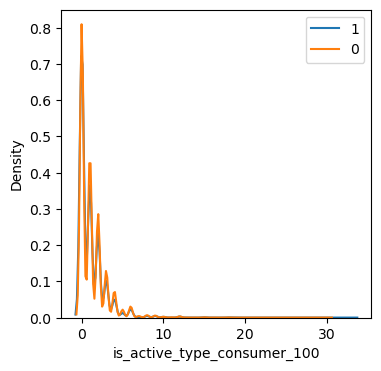

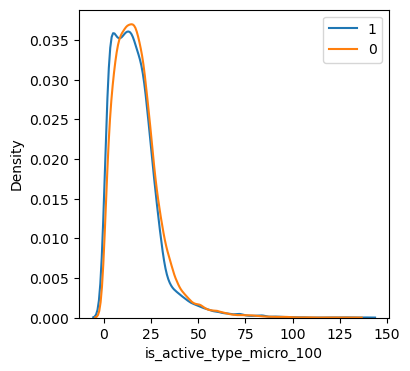

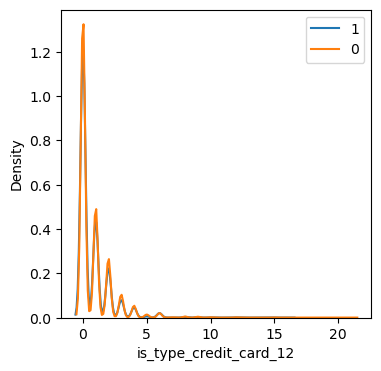

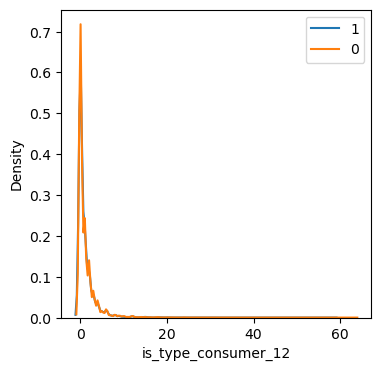

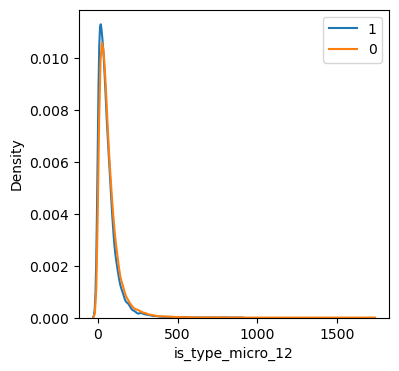

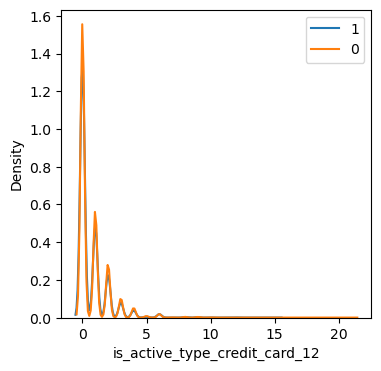

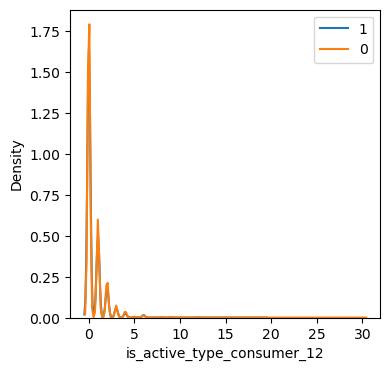

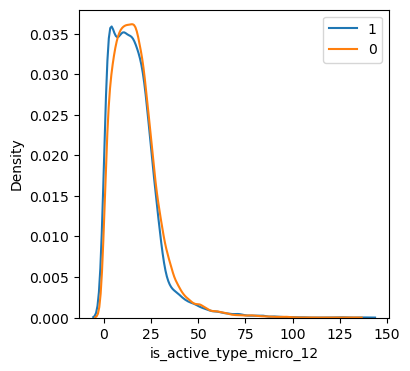

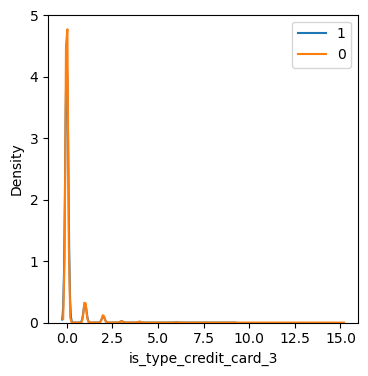

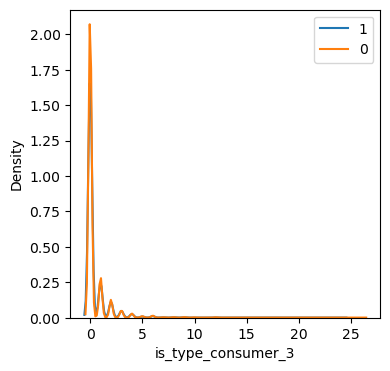

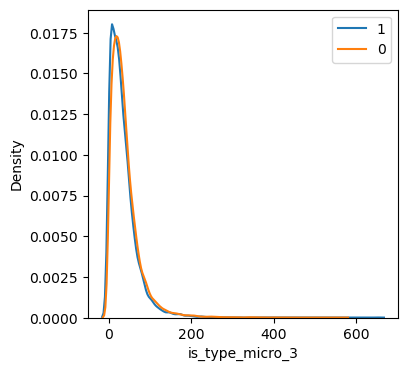

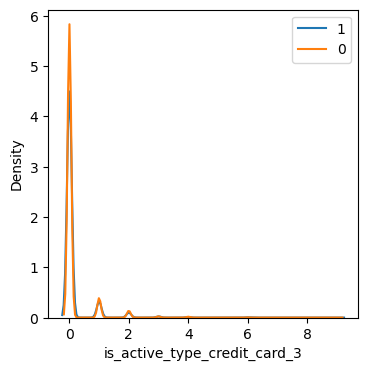

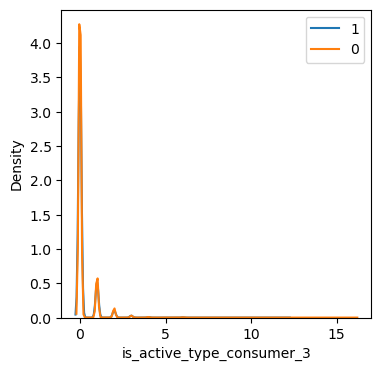

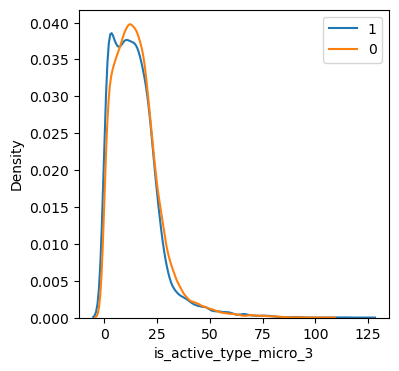

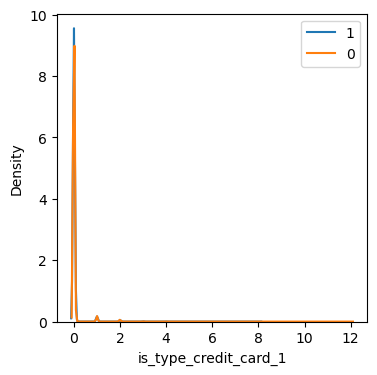

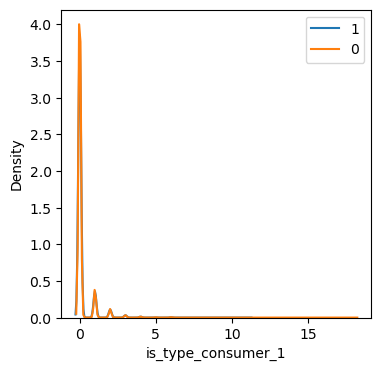

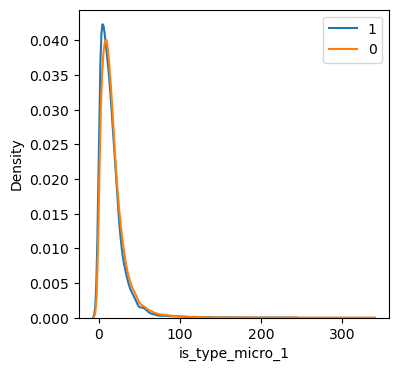

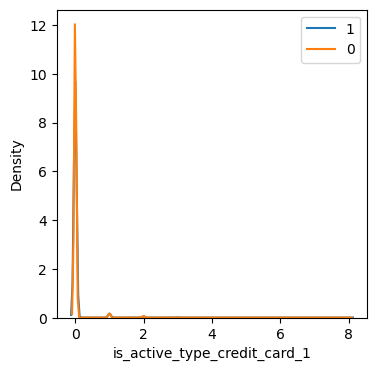

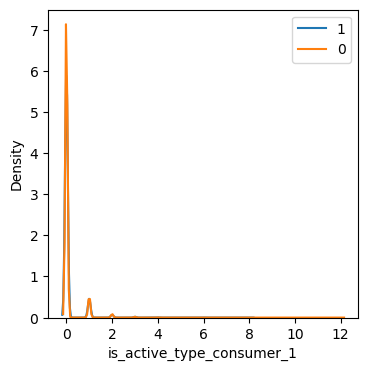

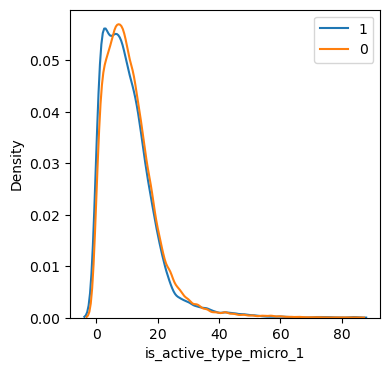

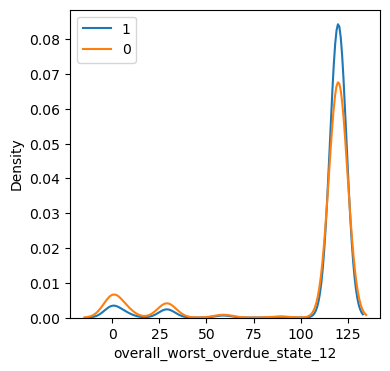

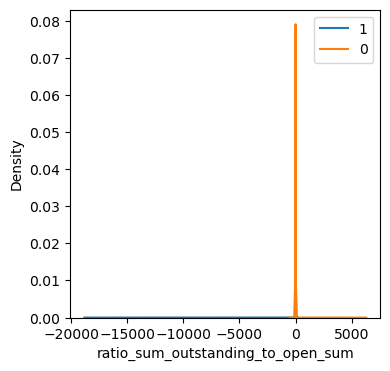

In [40]:
for i in X.columns:
    fig, axis = plt.subplots(1, 1, figsize=(4, 4))
    sns.kdeplot(target_1[i], label='1')
    sns.kdeplot(target_0[i], label='0')
    plt.legend()

По данным графикам сложно сказать об информативности признаков, например, потому что некоторые из признаков имеют выбросы, которые мешают увидеть выборку детально. Попробуем проанализировать значимость с помощью матрицы корреляций

In [41]:
corr_matrix = df_target.corr()

In [42]:
corr_matrix

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,is_active_12,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
age,1.000000,0.005756,0.023246,0.004518,0.024368,0.052992,0.023861,0.004227,0.106345,0.021533,...,0.004786,0.012294,0.031172,-0.051660,0.011429,0.041739,-0.028526,0.076642,0.000170,-0.028849
lastcredit,0.005756,1.000000,0.320690,0.014589,0.136632,-0.089839,-0.029653,0.017384,-0.069733,-0.105206,...,-0.109010,-0.009105,-0.024251,-0.090995,-0.009255,-0.021927,-0.107075,0.001986,-0.009092,0.026212
time_to_lastcredit_closeddt,0.023246,0.320690,1.000000,0.034549,0.069557,-0.052255,-0.030470,-0.018434,-0.043542,-0.053257,...,-0.056105,0.036466,-0.009363,-0.046264,0.038365,-0.005048,-0.050179,-0.053854,0.000196,0.012320
close_loan_median,0.004518,0.014589,0.034549,1.000000,0.168012,-0.033792,-0.015013,-0.002928,-0.026950,-0.033021,...,-0.032842,0.000586,-0.005904,-0.025799,0.000707,-0.004457,-0.030283,-0.000876,0.000212,0.019898
open_loan_median,0.024368,0.136632,0.069557,0.168012,1.000000,-0.096990,-0.045706,-0.022997,-0.078850,-0.096118,...,-0.097401,0.013049,-0.015487,-0.076516,0.013938,-0.010154,-0.090268,0.008948,0.000370,0.041073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
is_active_type_consumer_1,0.041739,-0.021927,-0.005048,-0.004457,-0.010154,0.223056,0.123532,-0.002671,0.186615,0.219620,...,0.188825,0.033624,0.781175,0.137605,0.035395,1.000000,0.164985,0.037602,0.000776,0.007957
is_active_type_micro_1,-0.028526,-0.107075,-0.050179,-0.030283,-0.090268,0.824923,0.291452,-0.080853,0.656174,0.870573,...,0.916351,0.023505,0.195209,0.857898,0.022042,0.164985,1.000000,-0.046582,0.003552,-0.037972
overall_worst_overdue_state_12,0.076642,0.001986,-0.053854,-0.000876,0.008948,-0.096020,0.069651,0.140283,-0.044000,-0.087690,...,-0.075619,-0.000946,0.055121,-0.017203,-0.002401,0.037602,-0.046582,1.000000,-0.001151,0.104638
ratio_sum_outstanding_to_open_sum,0.000170,-0.009092,0.000196,0.000212,0.000370,0.003946,0.001883,-0.001438,0.003018,0.003901,...,0.003742,0.000402,0.000843,0.002996,0.000410,0.000776,0.003552,-0.001151,1.000000,-0.008306


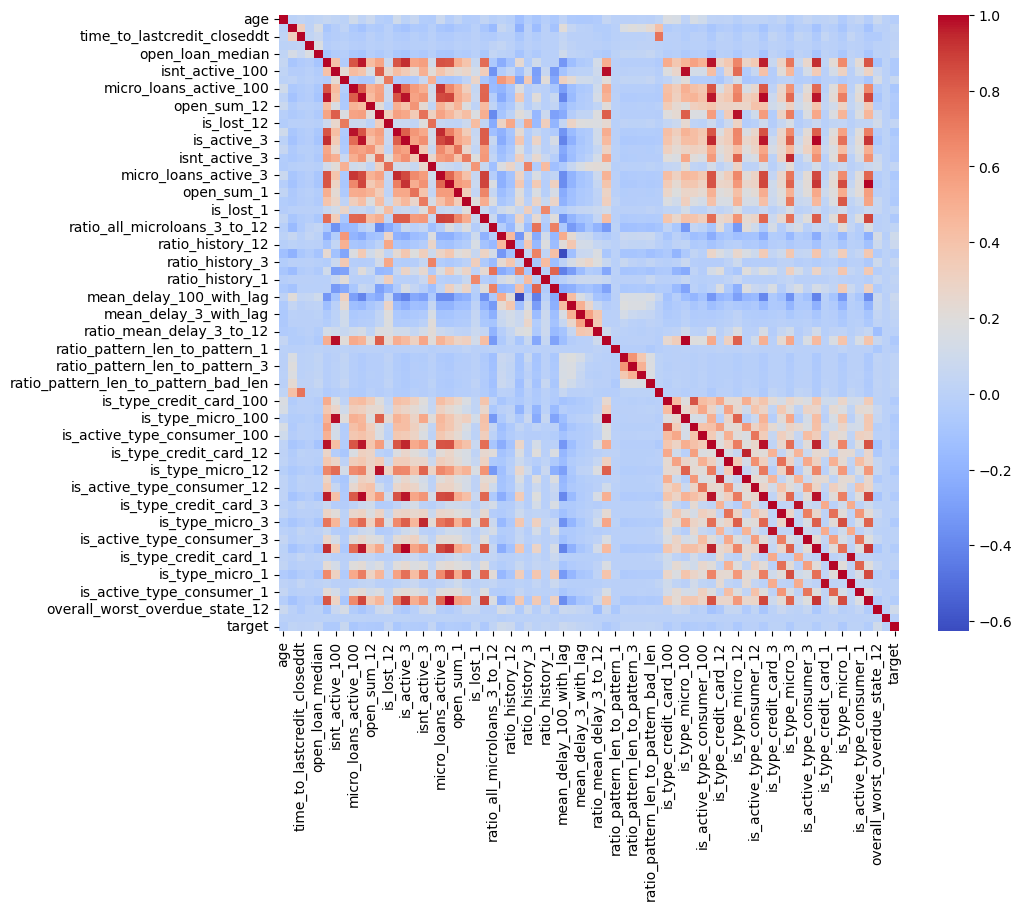

In [43]:
# Создание тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")

# Отображение графика
plt.show()

Ни один признак сильно не коррелирует с целевой переменной

Удаляем сильно скоррелированные признаки

In [44]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# задаем пороговое значение корреляции
threshold = 0.8

# находим индексы столбцов с корреляцией выше порогового значения
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# удаляем столбцы с высокой корреляцией из датасета
df.drop(to_drop, axis=1, inplace=True)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Анализ некоторых признаков

Посмотрим графики по некоторым признакам

- **age** - Возраст заемщика
- **lastcredit** - Время в днях, которое прошло с момента открытия последнего кредитного продукта
- **time_to_lastcredit_closeddt** - Время в днях, которое прошло с момента закрытия последнего микрокредита (если есть активные кредиты, эта переменная будет равна 0)

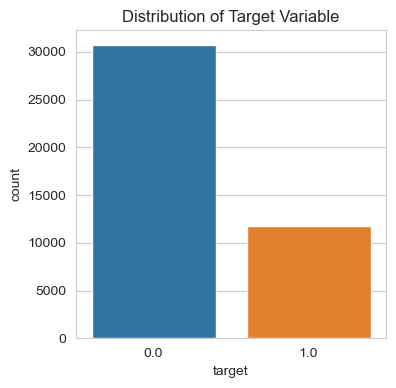

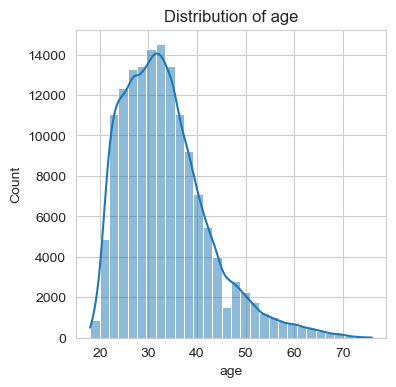

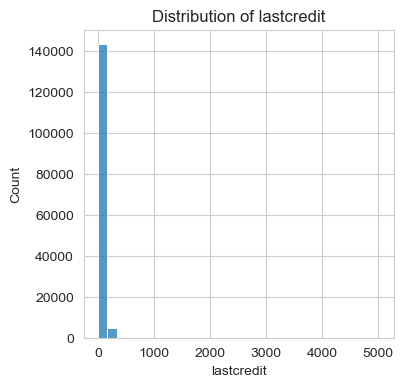

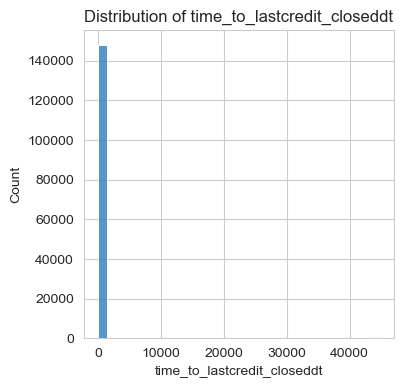

In [45]:
sns.set_style("whitegrid")

plt.figure(figsize=(4, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.show()

for i in ['age', 'lastcredit', 'time_to_lastcredit_closeddt']:
    fig, axis = plt.subplots(1, 1, figsize=(4, 4))
    if i == 'age':
        kde = True
    else:
        kde = False
    sns.histplot(data=df, x=i, bins=30, kde=kde)
    plt.title('Distribution of ' + i)
    plt.show()

Мало что можно сказать из данных признаках о клиентском профиле, но что-то всё-таки можно

Характеристики клиентского портфеля организации:
1. Возраст типичного клиента - 32 года, большинству клиентов от 23 до 45 лет
2. Большинство клиентов взяли последний кредит около 30 дней назад
3. Практически ни один клиент не имеет активных кредитов
4. Довольно большой процент клиентов обанкротились

## Отбор признаков c помощью shap

In [46]:
X = df[~df.target.isnull()].drop(columns=['target'])

In [47]:
y = df[~df.target.isnull()]['target']

Заполним значения Null в X

In [48]:
X.fillna(0, inplace=True)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Обучим модель

In [50]:
start = time.time()
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
end = time.time() - start

print('Время обучения модели:', end // 60, 'минут', end % 60, 'секунд')

Время обучения модели: 0.0 минут 16.353421211242676 секунд


In [51]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [52]:
mean_abs_shap_values = pd.DataFrame(abs(shap_values.values).mean(0), index=X_test.columns, columns=["mean_abs_shap"])

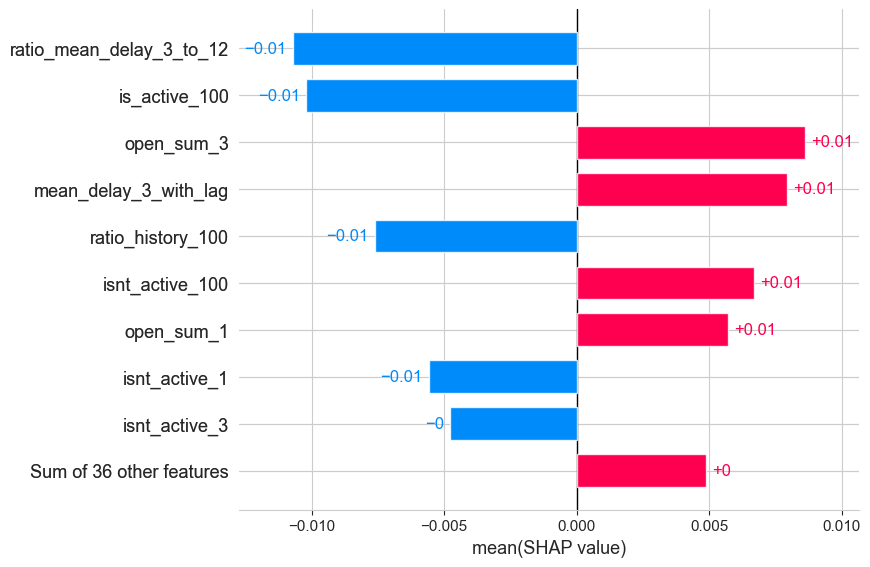

In [53]:
shap.plots.bar(shap_values.mean(0))

In [54]:
mean_abs_shap_values_sorted = mean_abs_shap_values.sort_values(by="mean_abs_shap", ascending=False)

In [55]:
mean_abs_shap_values_sorted

,mean_abs_shap
overall_worst_overdue_state_12,0.173230
is_active_100,0.164922
isnt_active_1,0.141010
fraction_last_x_1,0.113352
age,0.096273
isnt_active_3,0.094802
open_sum_12,0.088587
ratio_history_100,0.069505
isnt_active_100,0.052614
mean_delay_100_with_lag,0.051650


уберем все фичи ниже ratio_history_3

In [56]:
cols = mean_abs_shap_values_sorted[mean_abs_shap_values_sorted['mean_abs_shap'] > 0.016].index

# Кросс-валидация

In [57]:
X = X[cols]

In [58]:
model = CatBoostClassifier(verbose=False)

In [59]:
start = time.time()

cv_score = cross_val_score(model, X, y, scoring='roc_auc')

end = time.time() - start

print('Время выполнения кросс-валидации:', round(end // 60), 'минут', round(end % 60), 'секунд')

Время выполнения кросс-валидации: 1 минут 24 секунд


In [60]:
np.mean(cv_score)

0.5967797059389746

Метрика получилась не очень хорошей, но попробуем подобрать трешхолд

# Подбор threshold

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [75]:
start = time.time()
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
end = time.time() - start

print('Время обучения модели:', end // 60, 'минут', end % 60, 'секунд')

Время обучения модели: 0.0 минут 16.285157203674316 секунд


In [92]:
y_test_proba = model.predict_proba(X_test)[:, 1]

In [95]:
best_threshold = None
best_approval_rate = 0
best_bankruptcy_rate = 1

for threshold in np.linspace(0, 1, 1000):
    y_test_pred = (y_test_proba >= threshold).astype(int)
    
    approval_rate = 1 - y_test_pred.mean()
    bankruptcy_rate = y_test[y_test_pred == 0].mean()
    
    if (approval_rate >= 0.35) and (bankruptcy_rate < best_bankruptcy_rate):
        best_threshold = threshold
        best_approval_rate = approval_rate
        best_bankruptcy_rate = bankruptcy_rate

best_threshold, best_approval_rate, best_bankruptcy_rate

(0.22622622622622623, 0.3524800456100342, 0.1678123736352608)

Удалось получить порог, чтобы, одобрять не менее 35% клиентов при банкротстве среди одобренных не выше 17%.

То есть не хватило 2% до требуемого результата

# Рекомендации по изменению признакового пространства

Предлагаю добавить множество очевидных фичей, которые с большой вероятностью поднимут качество классификации:
1. Зарплата клиента
2. Пол клиента
3. Дата взятия последнего кредита (число, месяц и год)
4. Цель взятия микрокредита (если возможно получить такой признак)
5. Семейное положение
6. Количество детей
7. Образование
8. Наличие недвижимости
9. Город фактического проживания
10. Город, где прописан клиент

В данном датасете из очевидных признаков только возраст, вряд ли на нем можно получить высокое качество